<a href="https://colab.research.google.com/github/LiamDuero03/DS-Society-Project/blob/Liams-Branch/Full-Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Project Lab: Quick Start Guide

Welcome to our first society project!

Our problem statement: Can we predict a city's 'Feels Like' temperature (Apparent Temperature) based solely on its size, location, and humidity?

In [2]:
import pandas as pd
import requests
from google.colab import userdata

# 1. Data Sourcing & Integration
In this section, we demonstrate how a Data Scientist pulls data from two distinct sources:
1. **Local Data Sourcing:** Internal "proprietary" data (e.g., City Population).
2. **Live API:** Real-time data enrichment (Live Weather).

### 1.1 Local Data Sourcing (Automated)
Instead of manual uploads, we pull our "internal" population data directly from our GitHub repository. This ensures all members are working with the same version of the data.

* **Primary Data Source:** The underlying dataset is the **World Cities Database**, originally sourced from [Kaggle](https://www.kaggle.com/datasets/max-mind/world-cities-database).
* **Storage Method:** Due to the large file size (3.1+ million rows), the CSV is hosted using **Git LFS (Large File Storage)**. This allows us to bypass GitHub's standard file limits and stream the data directly into our environment via Raw GitHub URLs.
* **Automation:** By using `pd.read_csv()` on the hosted URL, we eliminate the need for users to download local copies or manage large files manually.

| Column | Description |
| :--- | :--- |
| **city** | Standardized city name (lowercased for merging) |
| **pop** | Total population count |
| **lat / lng** | Geographic coordinates (Latitude and Longitude) |

In [24]:
import pandas as pd

# --- CONFIGURATION ---
GITHUB_CSV_URL = "https://media.githubusercontent.com/media/LiamDuero03/DS-Society-Project/refs/heads/main/worldcitiespop.csv"

# --- 1. DATA LOADING ---
try:
    # Use 'usecols' to load only what we need (saves RAM)
    # Use lowercase column names if your CSV has them; otherwise keep these
    internal_metadata_df = pd.read_csv(
        GITHUB_CSV_URL,
        low_memory=False,
        usecols=['City', 'Population', 'Latitude', 'Longitude']
    )

    # Standardize column names for ease of use
    internal_metadata_df.columns = ['city', 'pop', 'lat', 'lng']

    print(f"✅ Successfully loaded {len(internal_metadata_df):,} rows from GitHub.")

except Exception as e:
    print(f"❌ Error: {e}")
    print("Tip: Check your GitHub LFS settings or the file URL.")

# --- 2. DATA CLEANING & SELECTION ---
# We focus on unique cities and prioritize the records with the highest population
valid_unique_cities = (
    internal_metadata_df
    .dropna(subset=['pop'])               # Remove rows without population data
    .sort_values(by='pop', ascending=False) # Put largest cities at the top
    .drop_duplicates(subset=['city'])     # Keep only the largest version of each city
)

# Extract the top 50 cities for our API target list
target_cities = valid_unique_cities.head(50)['city'].tolist()

# --- 3. SUMMARY OUTPUT ---
print(f"✅ Selected the top {len(target_cities)} unique megacities for analysis.")
print("-" * 30)
print(f"Top 5 Cities: {', '.join(target_cities[:5])}...")
print("-" * 30)

# Display the first few rows of our cleaned dataset
valid_unique_cities.head()

✅ Successfully loaded 3,173,958 rows from GitHub.
✅ Selected the top 50 unique megacities for analysis.
------------------------------
Top 5 Cities: tokyo, shanghai, bombay, karachi, new delhi...
------------------------------


,city,pop,lat,lng
1544449,tokyo,31480498.0,35.685000,139.751389
570824,shanghai,14608512.0,31.045556,121.399722
1327914,bombay,12692717.0,18.975000,72.825833
2200161,karachi,11627378.0,24.905600,67.082200
1349146,new delhi,10928270.0,28.600000,77.200000


## 1.2 Live API
#### 1.2.1 Get your OpenWeatherMap API Key

We are combining static city data with live weather data. You need a personal key to "talk" to the weather server:
1. Go to [OpenWeatherMap.org](https://openweathermap.org/api) and create a free account.
2. Navigate to your **API Keys** tab and copy your default key.
3. *Note:* It can take up to 30-60 minutes for a new key to "activate."

#### 1.2.2 🛡️ Set up Colab Secrets
To keep our project secure, we **never** type our API keys directly into the code.
* Look at the left-hand sidebar in this Colab window.
* Click the **Key icon (Secrets)** 🔑.
* Click "Add new secret".
* Name: `OPENWEATHER_API_KEY`
* Value: Paste your key here.
* **Toggle the "Notebook access" switch to ON.**



In [26]:
import os

# List of files to remove
files_to_delete = ['live_weather_cache.csv']

for file in files_to_delete:
    if os.path.exists(file):
        os.remove(file)
        print(f"🗑️ Deleted: {file}")
    else:
        print(f"⚠️ {file} not found (already deleted).")

🗑️ Deleted: live_weather_cache.csv


In [27]:
import os
import pandas as pd
import requests
from google.colab import userdata

# --- 1. API SETUP & CACHING LOGIC ---
try:
    API_KEY = userdata.get('OPENWEATHER_API_KEY')
    print("✅ OpenWeather API Key successfully retrieved.")
except:
    print("❌ API Key missing. Please add 'OPENWEATHER_API_KEY' to Colab Secrets.")

def fetch_live_weather(city_list):
    """
    Fetches real-time weather data for a list of cities.
    Saves results to a local CSV to prevent unnecessary API calls.
    """
    CACHE_FILE = "live_weather_cache.csv"

    # Check if we already have data from a previous run
    if os.path.exists(CACHE_FILE):
        print(f"📦 Loading weather data from local cache: {CACHE_FILE}")
        return pd.read_csv(CACHE_FILE)

    print(f"🌐 Cache not found. Fetching live data for {len(city_list)} cities...")
    results = []
    base_url = "http://api.openweathermap.org/data/2.5/weather"

    # Loop through cities and collect data
    for i, city in enumerate(city_list):
        params = {'q': city, 'appid': API_KEY, 'units': 'metric'}

        # Simple progress indicator for beginners
        if (i + 1) % 10 == 0:
            print(f"   Progress: {i + 1}/{len(city_list)} cities processed...")

        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                d = response.json()
                results.append({
                    'city_name': city.lower().strip(),
                    'temp': d['main']['temp'],
                    'feels_like': d['main']['feels_like'],
                    'humidity': d['main']['humidity'],
                    'pressure': d['main']['pressure'],
                    'condition': d['weather'][0]['description'],
                    'wind': d['wind']['speed']
                })
        except Exception as e:
            print(f"⚠️ Error fetching {city}: {e}")

    # Create DataFrame and save to CSV
    weather_df = pd.DataFrame(results)
    weather_df.to_csv(CACHE_FILE, index=False)
    print("✅ API calls complete. Results cached locally.")
    return weather_df

# --- 2. TARGET SELECTION ---
# We prioritize the top 50 unique cities with the highest verified populations
print("🧹 Cleaning population data to identify the top 50 target cities...")

# This logic ensures we get unique names and the highest recorded pop for each
valid_unique_cities = (
    internal_metadata_df.dropna(subset=['pop'])
    .sort_values(by='pop', ascending=False)
    .drop_duplicates(subset=['city'])
)

target_cities = valid_unique_cities.head(50)['city'].tolist()

# --- 3. EXECUTION ---
live_weather_df = fetch_live_weather(target_cities)

print("-" * 30)
print(f"📊 Weather Data Preview ({len(live_weather_df)} cities):")
live_weather_df.head()

✅ OpenWeather API Key successfully retrieved.
🧹 Cleaning population data to identify the top 50 target cities...
🌐 Cache not found. Fetching live data for 50 cities...
   Progress: 10/50 cities processed...
   Progress: 20/50 cities processed...
   Progress: 30/50 cities processed...
   Progress: 40/50 cities processed...
   Progress: 50/50 cities processed...
✅ API calls complete. Results cached locally.
------------------------------
📊 Weather Data Preview (50 cities):


,city_name,temp,feels_like,humidity,pressure,condition,wind
0,tokyo,5.00,1.04,76,1011,broken clouds,5.66
1,shanghai,5.92,1.70,61,1026,clear sky,7.00
2,bombay,24.99,25.35,69,1012,haze,2.06
3,karachi,15.90,15.56,77,1012,smoke,3.09
4,new delhi,12.09,11.81,94,1013,fog,2.57


## 1.3 The Master Merger
We will now join our **Baseline Data** with our **Local Metadata** and then ping the **OpenWeather API** to get live temperature data for a subset of these cities.

In [28]:
# 1. Standardize the join column in our cleaned metadata
valid_unique_cities['city_match'] = valid_unique_cities['city'].astype(str).str.lower().str.strip()

# 2. Perform the Merge
# IMPORTANT: We merge with valid_unique_cities (not internal_metadata_df)
# This ensures we only match the high-population, unique records we already picked
master_df = pd.merge(
    valid_unique_cities,
    live_weather_df,
    left_on='city_match',
    right_on='city_name',
    how='inner' # 'inner' keeps only the 50 cities we successfully matched
)

# 3. Final Polish
# We drop the extra join columns (no need to drop duplicates here because valid_unique_cities is already clean!)
master_df = master_df.drop(columns=['city_match', 'city_name'])

# 4. Final Column Selection
master_df = master_df[['city', 'pop', 'temp', 'feels_like', 'humidity', 'wind', 'condition', 'lat', 'lng']]

print(f"🚀 Master Dataset Created! Row count: {len(master_df)}")
master_df.head(10)

🚀 Master Dataset Created! Row count: 50


,city,pop,temp,feels_like,humidity,wind,condition,lat,lng
0,tokyo,31480498.0,5.00,1.04,76,5.66,broken clouds,35.685000,139.751389
1,shanghai,14608512.0,5.92,1.70,61,7.00,clear sky,31.045556,121.399722
2,bombay,12692717.0,24.99,25.35,69,2.06,haze,18.975000,72.825833
3,karachi,11627378.0,15.90,15.56,77,3.09,smoke,24.905600,67.082200
4,new delhi,10928270.0,12.09,11.81,94,2.57,fog,28.600000,77.200000
5,delhi,10928270.0,12.05,11.77,94,2.57,fog,28.666667,77.216667
6,manila,10443877.0,26.74,29.41,83,0.45,broken clouds,14.604200,120.982200
7,moscow,10381288.0,-7.81,-12.31,71,2.53,overcast clouds,55.752222,37.615556
8,seoul,10323448.0,-9.24,-14.70,57,3.09,clear sky,37.598500,126.978300
9,sao paulo,10021437.0,30.54,32.82,55,4.63,scattered clouds,-23.473293,-46.665803


#2. Preliminary EDA & Visualization
Goal: Understand the "shape" and "health" of the data.

## 2.1 Understanding the "Skeleton" (Structure)
First, we use basic Pandas commands to see what we are working with. Beginners should always start here to check for missing values or unexpected data types.

In [29]:
# Check the shape (Rows, Columns)
print(f"Dataset Dimensions: {master_df.shape}")

# See the data types and null counts
print("\n--- Data Summary ---")
print(master_df.info())

# Get basic statistics (Mean, Min, Max) for numerical columns
print("\n--- Numerical Statistics ---")
display(master_df.describe())

Dataset Dimensions: (50, 9)

--- Data Summary ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        50 non-null     object 
 1   pop         50 non-null     float64
 2   temp        50 non-null     float64
 3   feels_like  50 non-null     float64
 4   humidity    50 non-null     int64  
 5   wind        50 non-null     float64
 6   condition   50 non-null     object 
 7   lat         50 non-null     float64
 8   lng         50 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.6+ KB
None

--- Numerical Statistics ---


,pop,temp,feels_like,humidity,wind,lat,lng
count,5.000000e+01,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,6.970887e+06,14.26500,13.625400,68.880000,3.764400,19.525525,46.171401
std,4.584767e+06,12.74821,14.977366,20.782292,3.118977,22.717912,71.419071
min,3.519177e+06,-12.06000,-18.080000,13.000000,0.000000,-37.813938,-118.242778
25%,3.951126e+06,5.23000,1.205000,55.250000,1.655000,8.539422,3.520972
50%,5.388496e+06,16.54500,15.900000,70.500000,3.090000,24.314328,72.721250
75%,8.675764e+06,24.97750,25.590000,85.750000,4.630000,33.937361,104.013959
max,3.148050e+07,33.55000,38.560000,100.000000,19.670000,59.894444,151.205475


## 2.2 The "Big Picture" Analysis (Pairplots)

Once we know our data is clean, we want to see how different variables interact. Instead of making dozens of individual charts, we use a **Pairplot**. This is a powerful "all-in-one" visualization that helps us spot patterns across the entire dataset instantly.

---

#### What is happening in this visualization?

A Pairplot creates a matrix of charts. To read it like a pro, look at these three distinct areas:

1. **The Diagonal (The Curves):**
Running from the top-left to the bottom-right, you see **Distribution Plots** (KDE). These show you the "shape" of a single variable—for example, where most city temperatures are concentrated.
2. **The Scatter Plots (The Dots):**
Every other square shows the relationship between **two different variables**.
* If the dots form a clear line, the variables are **correlated**.
* If the dots look like a messy cloud, there is **no relationship**.


3. **The Red Regression Lines (`kind='reg'`):**
These lines represent the "best fit" for the data.
* **Sloping Up:** As one value goes up, the other tends to go up (e.g., Humidity vs. Feels Like).
* **Sloping Down:** As one value goes up, the other tends to go down.



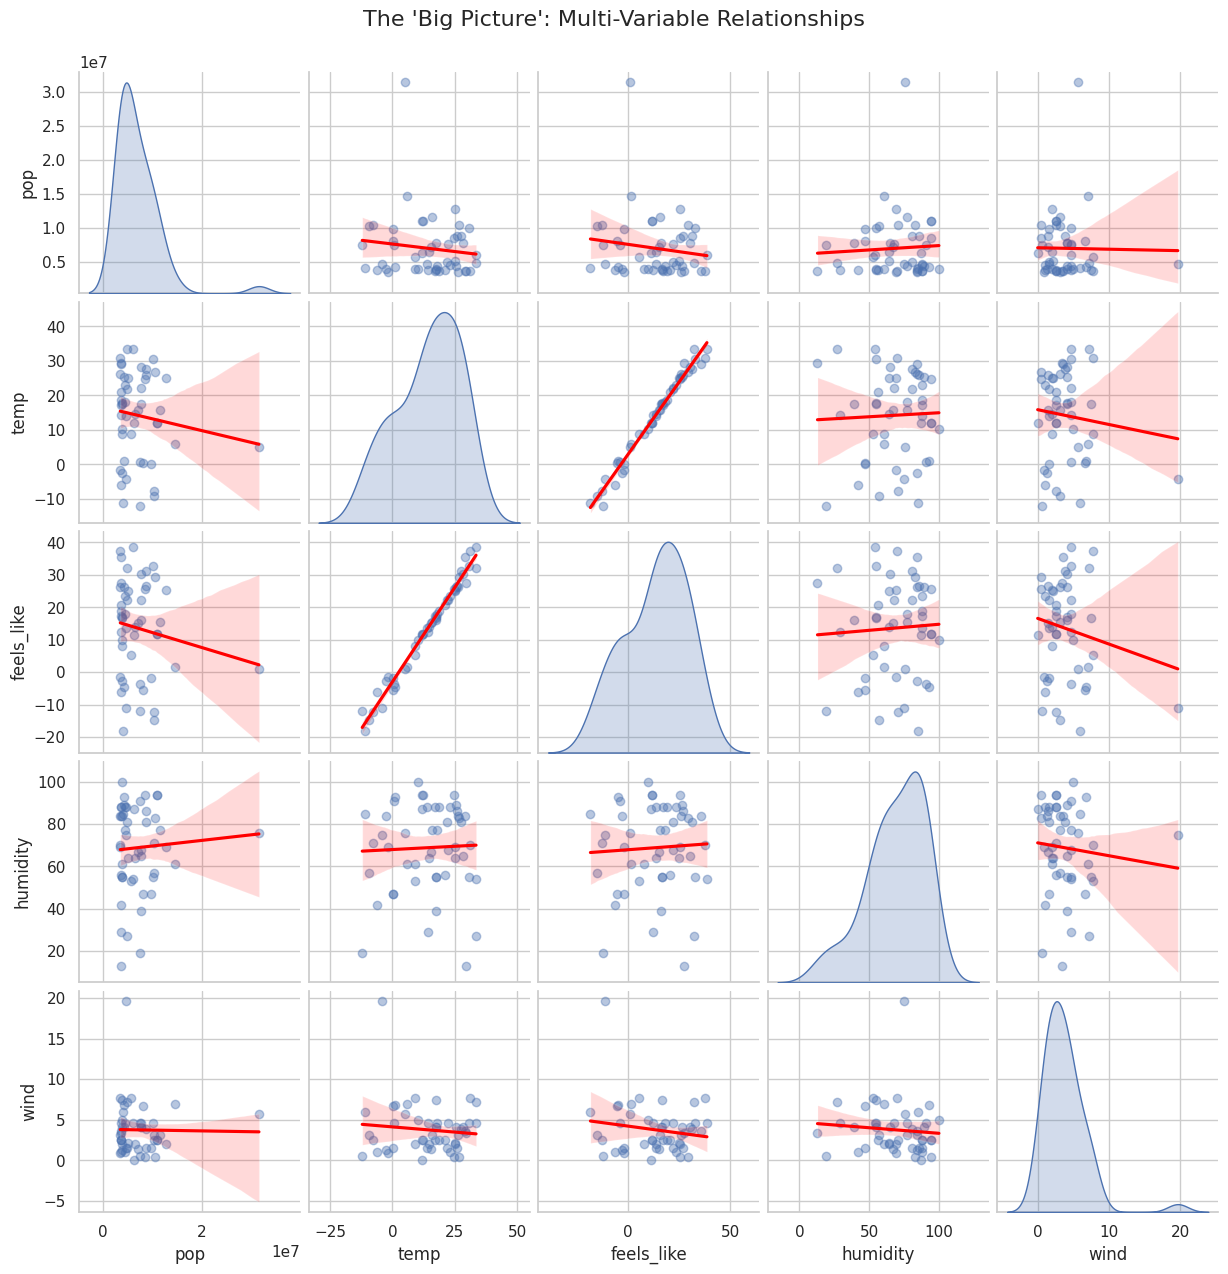

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. We select only the numerical columns that make sense for a beginner to compare
# We exclude lat/lng for now to focus on the 'Weather vs People' story
cols_to_plot = ['pop', 'temp', 'feels_like', 'humidity', 'wind']

# 2. Create the Pairplot
# 'diag_kind' shows the univariate distribution (histogram) on the diagonal
# 'kind=reg' adds a trend line to the scatter plots to show correlations
plot = sns.pairplot(
    master_df[cols_to_plot],
    diag_kind='kde',
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.4}}
)

# Add a title to the figure
plot.fig.suptitle("The 'Big Picture': Multi-Variable Relationships", y=1.02, fontsize=16)

plt.show()

## 2.3 The Correlation Heatmap
While the pairplot is visual, the Heatmap provides the exact mathematical correlation coefficient (Pearson's $r$). This is essential for a "Gold Template" because it allows you to say exactly how strong a relationship is on a scale of -1 to +1.

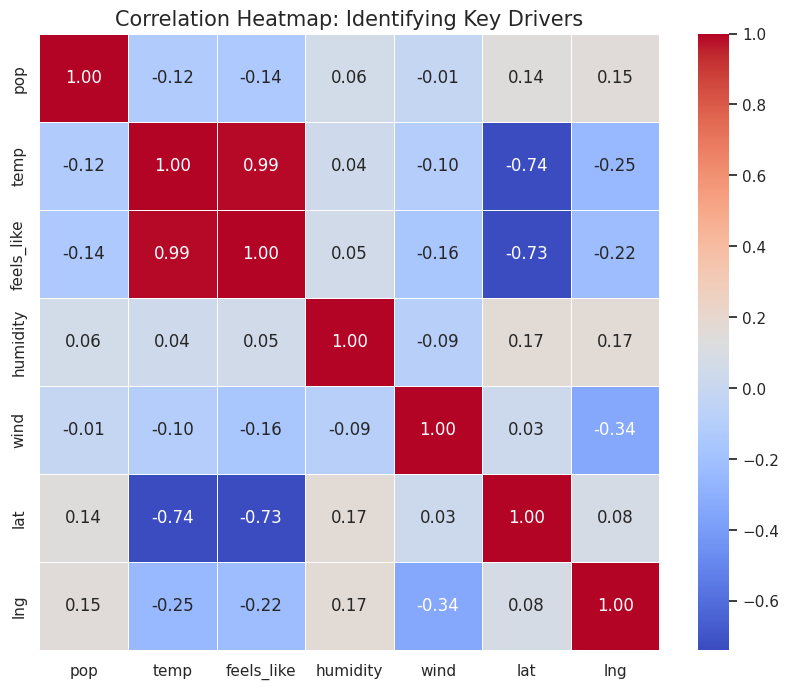

In [33]:
# Select numerical columns
numerical_df = master_df[['pop', 'temp', 'feels_like', 'humidity', 'wind', 'lat', 'lng']]

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Identifying Key Drivers", fontsize=15)
plt.show()

## 2.4 Spatial Mapping
You are working with global city data. A DS project feels incomplete if you don't show where these cities are. Using a simple scatter plot as a "map" is a brilliant way to show the relationship between Latitude and Temperature.

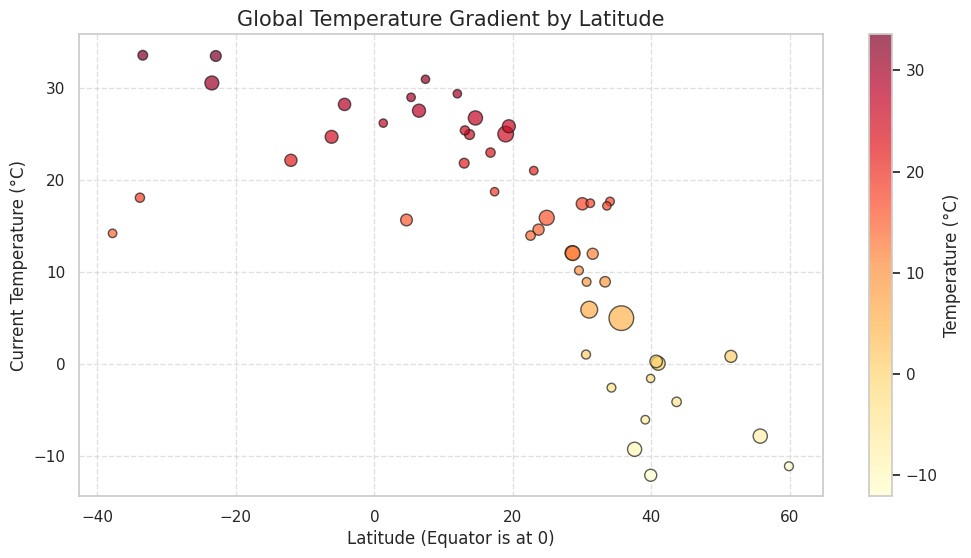

In [34]:
plt.figure(figsize=(12, 6))
# We use Latitude on the X-axis because it usually dictates temperature
scatter = plt.scatter(master_df['lat'], master_df['temp'],
                      c=master_df['temp'], cmap='YlOrRd',
                      s=master_df['pop']/100000, alpha=0.7, edgecolors='k')

plt.colorbar(scatter, label='Temperature (°C)')
plt.title('Global Temperature Gradient by Latitude', fontsize=15)
plt.xlabel('Latitude (Equator is at 0)', fontsize=12)
plt.ylabel('Current Temperature (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#3: Data Wrangling
Goal: Clean the data for the machine. This is where your team will spend most of their time.

In [ ]:
# --- SECTION 3: DATA WRANGLING ---
# 1. Handling Missing Values
df['column'] = df['column'].fillna(df['column'].median())

# 2. Encoding Categorical Variables
df = pd.get_dummies(df, columns=['category_column'], drop_first=True)

# 3. Feature Scaling (Week 4 topic)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# df[['num_cols']] = scaler.fit_transform(df[['num_cols']])

#4: Advanced Visualization
Goal: Storytelling. Move beyond simple bars to multi-dimensional charts.

In [ ]:
# --- SECTION 4: ADVANCED VISUALS ---
import plotly.express as px

# Create an interactive 3D scatter or a Correlation Heatmap
corr = df.corr()
fig = px.imshow(corr, text_auto=True, title="Feature Correlation Heatmap")
fig.show()

#5: Machine Learning (ML)
Goal: The predictive engine.

In [ ]:
# --- SECTION 5: MACHINE LEARNING ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # or Classifier

X = df.drop('target_column', axis=1)
y = df['target_column']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
print(f"Model Score: {model.score(X_test, y_test)}")